In [4]:
%load_ext autoreload
#nice magic to reload modules without kernelrestart --> important: it is maybee a bit bugy
%autoreload 2

import sys
%aimport -sys
import os
%aimport -os
print('Current working directory:', os.getcwd())

import numpy as np
%aimport -numpy
from timeit import default_timer as timer
%aimport -default_timer
import matplotlib.pyplot as plt
%aimport -matplotlib.pyplot
%matplotlib notebook
# or use "inline" instead
from PIL import Image
%aimport -Image
#%aimport

path_to_academia_ai = os.path.join(os.pardir, os.pardir)
if path_to_academia_ai not in sys.path:
    sys.path.append(path_to_academia_ai)
import academia_ai as ai
import academia_ai.preprocessing as preprocessing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current working directory: /Users/Dino/Dropbox/Academia2016/academia_AI/academia_ai/examples


# How to use Preprocessing:

<IPython.core.display.Javascript object>


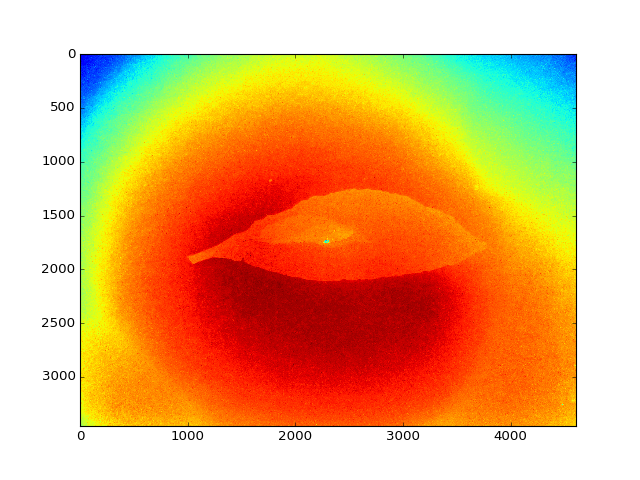

In [7]:
#lays all images ontop of each other --> the result image can be used to determine the interesting area of the
#pictures and determine the cutting borders
path = '/Users/Dino/Desktop/1'
maximum = preprocessing.find_overlap(path) # this function uses cutting borders whitch are (ATTENTION:) set constant in the code
plt.imshow(maximum)

In [8]:
#create individual images.npy and collects them to leafs/data/...
root_path = '/Users/Dino/Documents/Academia/2016_ArtificialIntelligence/Data-Leaf-Coded/'
save_path = '/Users/Dino/Dropbox/Academia2016/academia_AI/academia_ai/leafs/data/'
preprocessing.collectData(root_path, save_path, cfactor = 20, overwrite = False)
# die resultierende Grösse ist 2000 / cfactor 

KeyboardInterrupt: 

In [10]:
#create a training and a testing list
path = '/Users/Dino/Dropbox/Academia2016/academia_AI/academia_ai/leafs/data/80x80'
data = preprocessing.createTrainingAndTestingList(path, shuffle = False)
trainset = data[0]
testset = data[1]
#preprocessing.normalize(trainset)
#preprocessing.normalize(testset)

#take from training and testing only the matrixes, not the whole object leaf
training_images = [np.array(leaf.image) for leaf in trainset]
training_solutions = [preprocessing.desired_output(leaf.label) for leaf in trainset]
test_images = [np.array(leaf.image) for leaf in testset]
test_solutions = [preprocessing.desired_output(leaf.label) for leaf in testset]

<IPython.core.display.Javascript object>


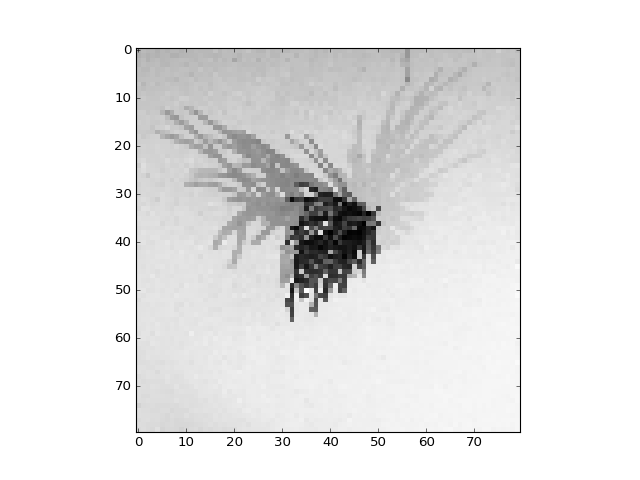

Shape of savedstuff: (882, 80, 80)


In [5]:
#test if the saved thing is useful
plt.imshow(test_images[550], interpolation = 'none', cmap ='Greys')
plt.colorbar
savedstuff = np.load('/Users/Dino/Dropbox/Academia2016/academia_AI/academia_ai/leafs/data/80x80/0.npy')
print('Shape of savedstuff:', savedstuff.shape)